In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import random
import keras
import h5py
import matplotlib.pyplot as plt
import bz2
import zipfile
import requests
import os
import gc
import timeit

In [2]:
# Import the labels
input_directory = "kaggle/input/histopathologic-cancer-detection/"
working_directory = "kaggle/working/"
tmp_directory = "kaggle/temp"


In [3]:
def download_file(url, folder_path, local_filename):
    # Make a request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses

    # Create the full path to the file
    file_path = os.path.join(folder_path, local_filename)

    # Write the file content in binary mode to the specified folder
    with open(file_path, 'wb') as file:
        file.write(response.content)



In [4]:
#Download Kaggle File
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/histopathologic-cancer-detection.zip'
folder_path = input_directory
local_filename = 'histopathologic-cancer-detection.zip'

download_file(url, folder_path, local_filename)

In [10]:
with zipfile.ZipFile(input_directory + "histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(input_directory)

In [11]:
directory = input_directory + "train_labels.csv"
images = pd.read_csv(directory)
images.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Cancer Free


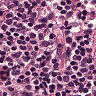

Cancer Free


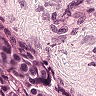

Cancer Free


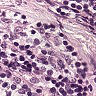

Cancer Free


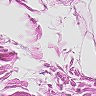

Cancer Free


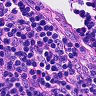

Cancer Free


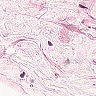

Cancer Free


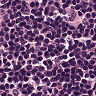

Cancer Free


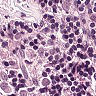

Cancerous


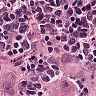

Cancer Free


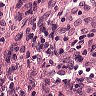

In [12]:
#print random images with lablels
samples = images.iloc[random.sample(range(0,images.shape[0]), 10)]
#print(samples)
for sample in samples.iterrows():
    #print(sample[1])
    path = input_directory + "train/" + str(sample[1]["id"]) + ".tif"
    if sample[1]["label"] == 0:
        print("Cancer Free")
    else:
        print("Cancerous")
    im = Image.open(path)
    display(im)


## EDA
- Cancerous vs Cancer Free numbers in train set
- Size of set
- Find more later

In [16]:
#GPT assisted class

def load_and_process_image(filename):
    path=input_directory + "train/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255
#Build Rotations


images['image_data'] = images['id'].apply(load_and_process_image)



In [17]:
# Store the results in a file for faster loading
X = np.stack(images['image_data'].values)
y = images['label'].values
path = working_directory + 'image_data.h5'
hdf5_file = path

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=X)
    f.create_dataset('labels', data=y)

In [18]:
#BZ2 Compress for cloud storage
with open(working_directory + "image_data.h5", 'rb') as input_file:
    with bz2.open(working_directory + "image_data.bz2", 'wb', compresslevel=9) as output_file:
        output_file.writelines(input_file)

## Expanding the training set

A good pratice in trianing image data is to rotate and shift the training set to create a better and more complete training set.  In researching this problem, just rotating all the images can create a 5% increase in accuracy if properly tuned.

In [16]:
# Download images non-rotated
url = 'https://storage.googleapis.com/isaac_blach_ml_storage/image_data.bz2'
folder_path = working_directory
local_filename = 'image_data.bz2'

download_file(url, folder_path, local_filename)

#unbz2 images for git storage
with bz2.open(working_directory + "image_data.bz2", 'rb') as compressed_file:
    with open(working_directory + "image_data.h5", 'wb') as decompressed_file:
        # Copy the decompressed data to a new file
        decompressed_file.write(compressed_file.read())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/image_data.bz2'

In [3]:
# Load dataset from file
path = working_directory + 'image_data.h5'
hdf5_file = path
with h5py.File(hdf5_file, 'r') as f:
    # Load the datasets back into memory
    X = f['images'][:]
    y = f['labels'][:]

In [4]:
# Rotate Images

def rotate_images(images, k):
    return np.rot90(images, k=k, axes = (1,2))

X_rotated = np.concatenate((X, rotate_images(X, 1), rotate_images(X, 2), rotate_images(X, 3)))
y_rotated = np.concatenate((y,y,y,y))

print("X Shape: " + str(X.shape))
print("X Rotated Shape: " + str(X_rotated.shape))
print("y Shape: " + str(y.shape))
print("y Shape: " + str(y_rotated.shape))

X Shape: (220025, 32, 32, 3)
X Rotated Shape: (880100, 32, 32, 3)
y Shape: (220025,)
y Shape: (880100,)


In [5]:
# Developed with help from https://keras.io/api/models/model/

def convolution_block(inputs, filters, activation = "ReLU"):
    filters = filters
    kernel_size=(3,3)
    conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=activation,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (inputs)
    return conv1

def pool_block(inputs):
    pool = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None
    )(inputs)
    return pool

def dropout_block(inputs, dropout_value):
    dropout = keras.layers.Dropout(dropout_value)(inputs)
    return dropout

def activation_block(inputs, layer_density): 
    dense = keras.layers.Dense(layer_density, activation='relu') (inputs)
    return dense

def prep_one_block():
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32)
        convolution = convolution_block(convolution, 32)
        convolution = pool_block(convolution)
        
    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation="sigmoid")(activation)
    full_model = keras.Model(inputs, outputs)
    return full_model



In [6]:
def run_model(full_model, learning_rate, X, y, epochs = 10):
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    full_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
    history = full_model.fit(
        x=X,
        y=y,
        batch_size=64,
        epochs=epochs,
        verbose=0,
        callbacks=None,
        validation_split=0.2,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    )
    return full_model, history
    


In [7]:
# Stolen Shamelessly from https://github.com/keras-team/keras/issues/12625 
# Clears up GPU out of memory
from tensorflow.keras import backend as K

# Reset Keras Session
def reset_keras():
    K.clear_session()
    gc.collect()

# Chatgpt wrote this imaging plot
def plot_error(train_accuracy, val_accuracy, text):
    epochs = range(1, len(train_accuracy) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-', color='red')

    # Loop through each epoch and add text annotation for training and validation accuracy
    for i, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy)):
        plt.text(i + 1, train_acc, f'{train_acc:.2f}', ha='center', va='bottom')
        plt.text(i + 1, val_acc, f'{val_acc:.2f}', ha='center', va='top')
    
    title_string = text
    plt.title(title_string)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')  # Changed 'Loss' to 'Accuracy' as we are plotting accuracy values
    plt.legend()
    plt.grid(True)
    plt.show()

1808.5335461000213


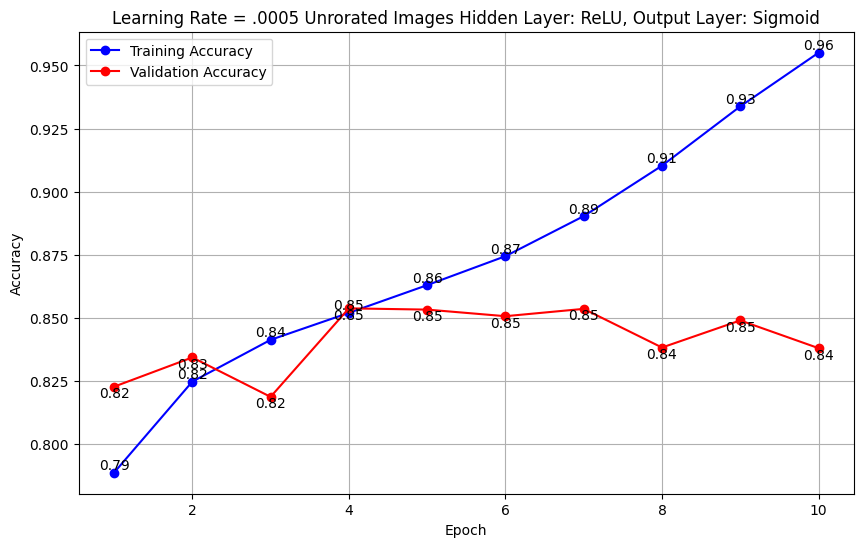

In [8]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X, y)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Unrorated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
model = None
reset_keras()

In [ ]:
model = prep_one_block()
start_time = timeit.default_timer()
_, history = run_model(model, .0005, X_rotated, y_rotated)
print(timeit.default_timer() - start_time)
text = "Learning Rate = .0005 Rotated Images Hidden Layer: ReLU, Output Layer: Sigmoid"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
model = None
reset_keras()

## Initial Impressions
.85 Validation with the unrotated images is ok.  With rotated Images, I'm getting .89. but after the 5-8th epoch, there is major overfitting.

## Testing different hidden layers and output layers
I'm going to try this with different hidden layer options.  I'm testing all the hidden layers avaliable.  I also dropped the number of epochs to make more sense.

In [ ]:
# Test different hidden layers
output_layers = ["Sigmoid", "Softmax", "Tanh", "PReLU"]
output_layer = ["Sigmoid"]
hidden_layers = ["PReLU"]
for hidden_layer in hidden_layers:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation="sigmoid")(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    
    
    _, history = run_model(full_model, .0005, X_rotated, y_rotated, epochs = 8)
    print(timeit.default_timer() - start_time)
    text = "Learning Rate = .0005 Unrorated Images Hidden Layer: " + hidden_layer + "Output Layer: " + output_layer
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    full_model = None
    reset_keras()

In [ ]:
# Test different hidden layers

output_layers = ["Softmax", "Tanh", "PReLU"]
hidden_layer = "PReLU"
for output_layer in output_layers:
    dropout_value = .25
    inputs = keras.Input(shape=(32,32,3))
    convolution = inputs
    for i in range(0,1):
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = convolution_block(convolution, 32, hidden_layer)
        convolution = pool_block(convolution)

    flatten= keras.layers.Flatten()(convolution)

    activation = flatten
    for i in range(0,1):
        activation = activation_block(activation,1024)
        activation = dropout_block(activation, dropout_value)
    outputs = keras.layers.Dense(1, activation=output_layer)(activation)
    full_model = keras.Model(inputs, outputs)
    start_time = timeit.default_timer()
    
    
    _, history = run_model(full_model, .0005, X_rotated, y_rotated)
    print(timeit.default_timer() - start_time)
    text = "Learning Rate = .0005 Unrorated Images Hidden Layer: " + hidden + "Output Layer: " + output_layer
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    full_model = None
    reset_keras()

## Best Hidden and Output Layer
I will continue with PReLU.  PReL
## Number of convolutional layers
There is a upper bound on the number of convolutional layers.  This is due to the very small size of the images.


In [ ]:
# Convolutional layers
learning_rate = .0005
conv = 2
dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
for i in range(0,conv):
    convolution = convolution_block(convolution, 32)
    convolution = convolution_block(convolution, 32)
    convolution = pool_block(convolution)
flatten= keras.layers.Flatten()(convolution)
activation = flatten
for i in range(0,1):
    activation = activation_block(activation,1024)
    activation = dropout_block(activation, dropout_value)
    
outputs = keras.layers.Dense(1, activation="sigmoid")(activation)
full_model = keras.Model(inputs, outputs)

text = "Number of Convolutional Layers: " + str(conv) + " Learning Rate: " + str(learning_rate)
print(text)

_, history = run_model(full_model, learning_rate)
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
full_model = None
reset_keras()
    

## Results
.82 is an improvement.  I had to immidiatly update my target learning rate.  The increased model component definitly affected the outcome.  

## Tuning Dense Blocks
The dense blocks are the meat of the learning process.  I have to be carefull to have enough to make a desicion but not too many as to prevent overfitting.  Part of this will be to tune the dropout rate of the dense blocks.

I hav chosen to do 2 blocks of 1024 or 32x32 bits and 1 of 256 bits.  I'm expecting wild overfitting.


In [ ]:
# Convolutional layers
learning_rate = .0005
conv = 2
dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
#Load the convolution and pool actions
for i in range(0,conv):
    convolution = convolution_block(convolution, 32)
    convolution = convolution_block(convolution, 32)
    convolution = pool_block(convolution)
flatten= keras.layers.Flatten()(convolution)
activation = flatten
# run 3 Dense Blocks with a 25% dropout rate  The first 2 dense blocks are 1024 or 32x32.  The final is 256.  
activation = activation_block(activation,1024)
dropout = dropout_block(activation, dropout_value)

activation = activation_block(dropout,1024)
dropout = dropout_block(activation, dropout_value)

activation = activation_block(dropout,256)
dropout = dropout_block(activation, dropout_value)

outputs = keras.layers.Dense(1, activation="sigmoid")(dropout)
full_model = keras.Model(inputs, outputs)

text = "Number of Convolutional Layers: " + str(conv) + " Learning Rate: " + str(learning_rate)
print(text)

_, history = run_model(full_model, learning_rate)
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
reset_keras()

This is a supprise.  This caused a net decrease in the accuracy.  I also didn't see the high level of overfitting I expected.

## I'm going to try increasing the dropout rate and dropping the learning rate.
I'm going to try to tune the number of filters in each layer of the Conv-Conv-Pool cycle.  I'll start with 64 convolution filters.

In [ ]:
# Convolutional layers
learning_rate = .0001
conv = 2
dropout_value = .25
inputs = keras.Input(shape=(32,32,3))
convolution = inputs
#First Convolution Cycle
convolution = convolution_block(convolution, 64)
convolution = convolution_block(convolution, 64)
convolution = pool_block(convolution)

#Second Convolution Cycle
convolution = convolution_block(convolution, 64)
convolution = convolution_block(convolution, 64)
convolution = pool_block(convolution)

flatten= keras.layers.Flatten()(convolution)
activation = flatten

# Run Dense Blocks
activation = activation_block(activation,1024)
dropout = dropout_block(activation, dropout_value)

outputs = keras.layers.Dense(1, activation="sigmoid")(dropout)
full_model = keras.Model(inputs, outputs)

text = "Number of Convolutional Layers: " + str(conv) + " Learning Rate: " + str(learning_rate)
print(text)

_, history = run_model(full_model, learning_rate)
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
reset_keras()

## More Dropout layers
Ok, back from scratch to try other things.  I'll now try other 